In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 6


# Train model 

In [90]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/10
432038/432038 [==============================] - 5s 10us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9993
Epoch 2/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 3/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 4/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 5/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 6/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9993
Epoch 7/10
432038/432038 [==============================] - 4s 8us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0032 

# Learning curves

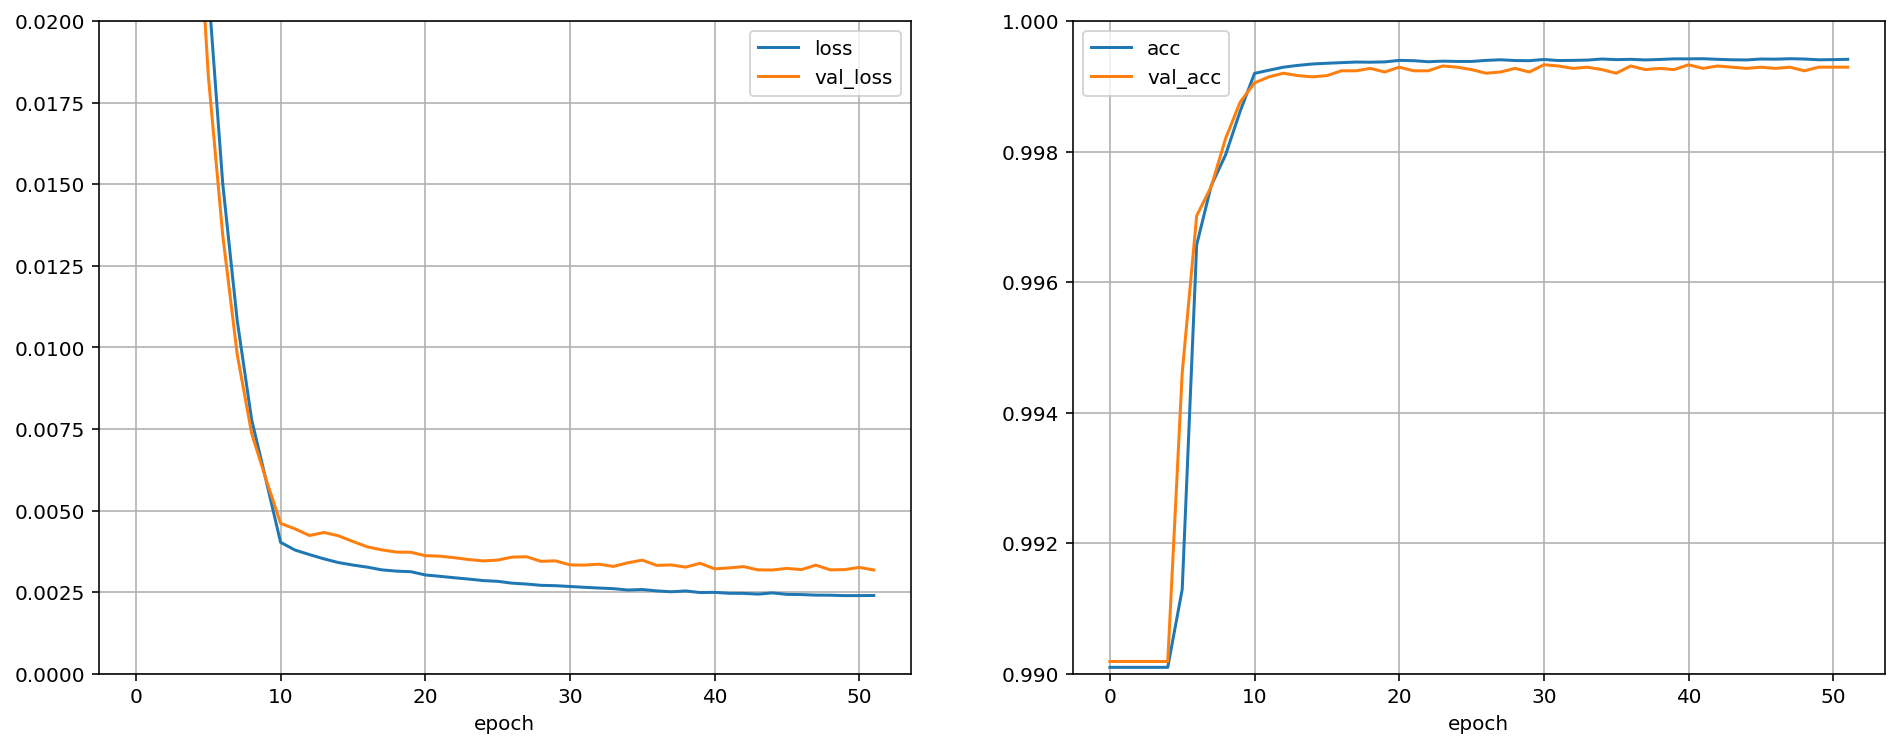

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [70]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       1.00      0.92      0.96       530

avg / total       1.00      1.00      1.00     54004

[[53472     2]
 [   40   490]]


In [71]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
49761,conf/vldb/FangSGMU98,computing iceberg queries efficiently,fang shivakumar motwani ullman,vldb,1998,E7yZtVJa2xAJ,computing iceberg queries 1996 int,fang shivakumar hg molina motwani jd,very large data bases,0.0
1026,conf/vldb/AgrawalS94,fast algorithms for mining association rules in large databases,agrawal srikant,vldb,1994,3MzTom30SiMJ,fastalgorithmsformining association rules,rar srikant,of the vldb conference santiago chile september,0.0
2016,conf/sigmod/ChandrasekaranCDFHHKMRS03,telegraphcq continuous dataflow processing,chandrasekaran cooper deshpande franklin hellerstein hong krishnamurthy madden reiss shah,sigmod conference,2003,eOhZfLS25AsJ,telegraphcq continuous dataflow processing for an uncertain world,chandrasekaran cooper deshpande mj,nan,0.0
6333,conf/vldb/KahveciS01,efficient index structures for string databases,kahveci singh,vldb,2001,i6KmypFd39AJ,singh ak efficient index structures for string databases,kahveci,of the international conference on very large data,0.0
17181,journals/sigmod/CasatiDS00,vldb workshop on technologies in tes,nan,nan,2000,pJsnj7fi9LIJ,report on the vldb workshop on technologies for tes cairo egypt september 14 and 15,casati,sigmod record,2000.0


# Save model and histories 

In [72]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1-num.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1-num')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1-num')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99953   0.99998   0.99976     53467
          1    0.99805   0.95353   0.97529       538

avg / total    0.99952   0.99952   0.99951     54005

[[53466     1]
 [   25   513]]
